In [1]:
import numpy as np
import seaborn as sns
from tqdm import tqdm # progress bar
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.preprocessing import LabelEncoder

In [ ]:
# shape of the image : 50x50
# number of classes : 62
# number of train images : 487_227
# number of test images : 155_489
# number of validation images : ??? (je sais plus)

# Get Data
---

- Récupération des données de la base de données
- formattage des données
- répartition des données

In [2]:
# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017/Scibio")  # Remplacez par l'URL de votre serveur MongoDB
db = client["Scribio"]  # Nom de la base de données
collection = db["Dataset"]  # Nom de la collection
# Temps : 0.0s

In [3]:
def fetch_data(repartition: str, nbr: int) -> tuple[np.array, np.array]:
    query = {"Repartition": repartition}
    documents = collection.find(query)
    print(f"fetch {repartition} OK !!!")

    images = []
    labels = []
    
    # Parcours et transformation des photos avec barre de progression 
    with tqdm(total=nbr, desc="Proccessing" , position=0, leave=True) as pbar:
        for doc in documents:
            images.append(np.array(doc["Tableau_Pixels"], dtype=np.float32))
            labels.append(doc["Label"])
            pbar.update(1) # Mettre à jour la barre de progression
            
    return np.array(images), np.array(labels, dtype=str)

In [4]:
# Recupération des données d'entrainement
X_train, y_train = fetch_data("train", 487_227)
# Temps : 5m 45.0s (en premier)

fetch train OK !!!


Proccessing: 100%|██████████| 487227/487227 [05:01<00:00, 1614.60it/s]


In [5]:
# Recupération des données de test
X_test, y_test = fetch_data("test", 155_489)
# Temps : 47min 25.8s (en deuxième)
# Temps : 7m 14.4s (en premier)

fetch test OK !!!


Proccessing: 100%|██████████| 155489/155489 [35:18<00:00, 73.39it/s]  


In [6]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder = LabelEncoder()

y_train2 = label_encoder.fit_transform(y_train)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test2 = label_encoder.transform(y_test)

In [7]:
# Correspondance indices ↔ labels
correspondance = dict(enumerate(label_encoder.classes_))
print(correspondance)

# Liste des labels
labels = list(correspondance.values())
print(labels)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
# Afficher quelques informations
print(f"Taille de X_train: {X_train.shape}, y_train: {y_train.shape}, y_train2: {y_train2.shape}")
print(f"Taille de X_test: {X_test.shape}, y_test: {y_test.shape}, y_test2: {y_test2.shape}")

Taille de X_train: (487227, 2500), y_train: (487227,), y_train2: (487227,)
Taille de X_test: (155489, 2500), y_test: (155489,), y_test2: (155489,)


# Premier NN 
---

Modèle proposé par ChatGPT

In [15]:
# Reseau de neurones
model1 = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(1024, activation='relu'), # hidden layer : 1024 neurones avec fonction d'activation relu
    # keras.Dropout(0.3), # Dropout layer pour éviter le surapprentissage (overfitting)
    keras.layers.Dense(512, activation='relu'), # hidden layer : 512 neurones avec fonction d'activation relu
    # keras.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'), # hidden layer : 256 neurones avec fonction d'activation relu
    # keras.Dropout(0.3),
    keras.layers.Dense(62, activation='sigmoid') # output layer : 62 classes (0-9, A-Z, a-z) avec softmax pour la classification
])

model1.compile(
    optimizer='adam', # optimizer : Adam avec learning rate de 0.0001
    loss='sparse_categorical_crossentropy', # loss : sparse_categorical_crossentropy pour la classification
    metrics=['accuracy'] # metrics : accuracy pour évaluer la performance du modèle
)

In [16]:
model1.fit(X_train, y_train2, epochs=10)
# accuracy: 0.7989
# loss: 0.6458
# Temps : 30m 49.4s

Epoch 1/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 170s 11ms/step - accuracy: 0.7093 - loss: 0.9835
Epoch 2/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 186s 12ms/step - accuracy: 0.7835 - loss: 0.6834
Epoch 3/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 187s 12ms/step - accuracy: 0.7888 - loss: 0.6629
Epoch 4/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 187s 12ms/step - accuracy: 0.7944 - loss: 0.6507
Epoch 5/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 184s 12ms/step - accuracy: 0.7960 - loss: 0.6452
Epoch 6/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 187s 12ms/step - accuracy: 0.7967 - loss: 0.6445
Epoch 7/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 187s 12ms/step - accuracy: 0.7979 - loss: 0.6439
Epoch 8/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 187s 12ms/step - accuracy: 0.7987 - loss: 0.6414
Epoch 9/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 186s 12ms/step - accuracy: 0.7981 - loss: 0.6467
Epoch 10/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 187s 12ms/step - accuracy: 0.7989 - loss: 0.6458


In [ ]:
# Sauvegarder le modèle
model1.save("../models/Scribio_model1.keras")  # Format keras (.keras)

In [18]:
y_predicted1 = model1.predict(X_test)
y_predicted1[1]

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


array([1.54816476e-07, 6.51092418e-12, 2.59204199e-07, 1.84621294e-11,
       3.28045935e-05, 2.06197837e-10, 2.63501027e-12, 3.54215546e-09,
       3.53376606e-10, 2.68538889e-11, 1.68372854e-03, 5.71229619e-10,
       1.22979798e-19, 4.22761201e-11, 3.66349395e-09, 2.37660007e-08,
       1.04611686e-13, 1.11882564e-05, 6.64998384e-13, 3.04607774e-20,
       2.46851140e-09, 2.28363846e-18, 1.72819784e-06, 4.45656451e-06,
       4.82497595e-17, 7.20545131e-07, 2.88391842e-13, 9.58010241e-06,
       6.33642942e-19, 3.20137065e-13, 4.62092251e-14, 1.18947119e-28,
       1.74253233e-16, 8.59546131e-14, 5.49429389e-20, 5.55901117e-22,
       6.37367411e-05, 4.60935577e-14, 6.11309535e-21, 8.11542833e-08,
       4.41314429e-10, 1.89350076e-12, 2.22706760e-08, 4.32874876e-05,
       4.24620408e-12, 7.93330956e-10, 1.21742847e-08, 9.02186366e-13,
       5.15169712e-11, 2.03668287e-06, 1.52071391e-19, 1.97652682e-07,
       2.52478616e-09, 1.10028741e-05, 6.20009415e-14, 1.69530324e-06,
      

In [19]:
np.argmax(y_predicted1[1])

10

In [27]:
# y_predicted_labels1 = np.array([correspondance[np.argmax(i)] for i in y_predicted1])
y_predicted_labels1 = [np.argmax(i) for i in y_predicted1]
y_predicted_labels1[:5]

[10, 10, 10, 10, 10]

In [28]:
y_test2[:5]

array([10, 10, 10, 10, 10])

Text(95.72222222222221, 0.5, 'Truth')

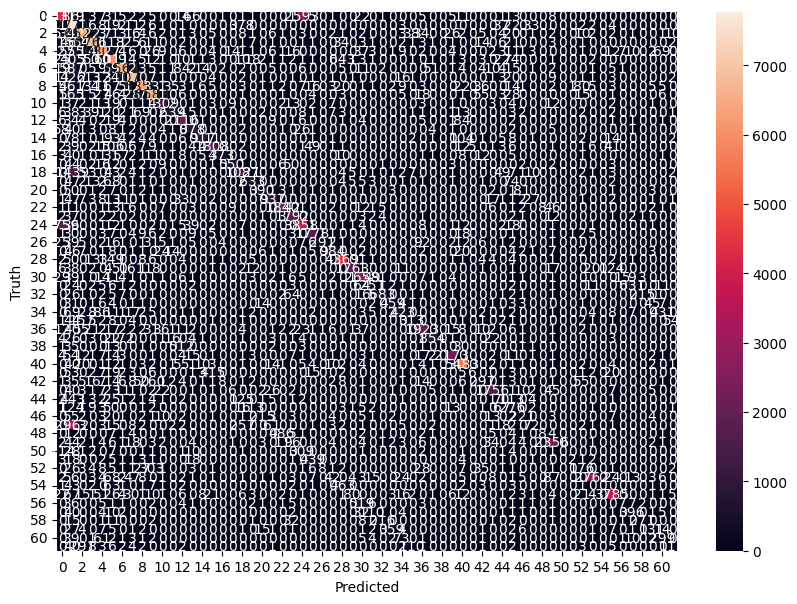

In [29]:
# Matrice de confusion
cm1 = tf.math.confusion_matrix(labels=y_test2, predictions=y_predicted_labels1)
plt.figure(figsize=(10, 7))
sns.heatmap(cm1, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Deuxième NN
---

Test perso 1
- diviser par 4 pour chaque couches en partant de 2500 (nbr d'entrées)

In [30]:
model2 = keras.Sequential([
    keras.layers.Input((2500,)),
    keras.layers.Dense(625, activation='relu'),
    keras.layers.Dense(156, activation='relu'),
    keras.layers.Dense(62, activation='sigmoid')
])

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
model2.fit(X_train, y_train2, epochs=10)
# accuracy: 0.8036
# loss: 0.6128
# Temps : 15m 5.0s

Epoch 1/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.7112 - loss: 0.9887
Epoch 2/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.7839 - loss: 0.6777
Epoch 3/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - accuracy: 0.7918 - loss: 0.6485
Epoch 4/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 95s 6ms/step - accuracy: 0.7959 - loss: 0.6354
Epoch 5/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 95s 6ms/step - accuracy: 0.7987 - loss: 0.6259
Epoch 6/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - accuracy: 0.8001 - loss: 0.6231
Epoch 7/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - accuracy: 0.8013 - loss: 0.6176
Epoch 8/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - accuracy: 0.8013 - loss: 0.6140
Epoch 9/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - accuracy: 0.8019 - loss: 0.6166
Epoch 10/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - accuracy: 0.8036 - loss: 0.6128


In [32]:
# Sauvegarder le modèle
model2.save("../models/Scribio_model2.keras")  # Format keras (.keras)

In [33]:
y_predicted2 = model2.predict(X_test)
y_predicted2[1]

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


array([6.63204340e-18, 3.91732059e-19, 1.59299700e-17, 3.02539681e-19,
       2.67218517e-12, 1.30502298e-14, 1.95080821e-22, 4.40902513e-16,
       1.22804732e-15, 1.36613816e-17, 6.30873899e-07, 5.67774705e-20,
       1.43389659e-34, 6.97085712e-15, 2.29921365e-19, 4.63771296e-12,
       5.04010835e-31, 3.24221037e-13, 4.98389038e-11, 3.34715887e-28,
       1.24610452e-11, 2.60287980e-32, 1.19451272e-11, 6.67090383e-10,
       2.57504243e-22, 1.48357476e-12, 0.00000000e+00, 2.04853726e-13,
       7.83178950e-27, 2.77561481e-11, 1.12933751e-16, 3.34754275e-20,
       4.20642486e-19, 6.48531749e-12, 1.04579361e-17, 1.95046303e-25,
       4.20091469e-16, 2.88109259e-24, 0.00000000e+00, 8.25903541e-14,
       5.99862719e-15, 1.02610704e-15, 1.03115075e-20, 1.72792614e-09,
       8.49682968e-25, 1.84204366e-20, 1.32762623e-14, 8.25177032e-23,
       3.21893199e-20, 4.96824581e-09, 0.00000000e+00, 1.60300747e-16,
       1.57298384e-19, 5.34253815e-08, 1.34700080e-26, 5.52237633e-09,
      

In [34]:
np.argmax(y_predicted2[1])

10

In [35]:
# y_predicted_labels2 = [correspondance[np.argmax(i)] for i in y_predicted2]
y_predicted_labels2 = [np.argmax(i) for i in y_predicted2]
y_predicted_labels2[:5]

[10, 10, 10, 10, 10]

Text(95.72222222222221, 0.5, 'Truth')

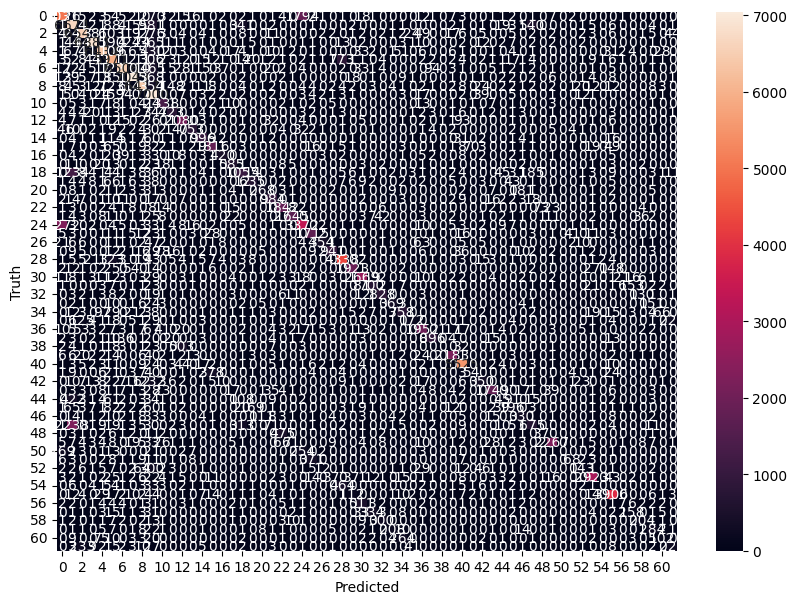

In [36]:
# Matrice de confusion
cm2 = tf.math.confusion_matrix(labels=y_test2, predictions=y_predicted_labels2)
plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Troisième NN
---

Test perso 2
- multiplier par 4 pour chaque couches en partant de 62 (nbr de sorties)

In [37]:
model3 = keras.Sequential([
    keras.layers.Input((2500,)),
    keras.layers.Dense(1984, activation='relu'),
    keras.layers.Dense(992, activation='relu'),
    keras.layers.Dense(248, activation='relu'),
    keras.layers.Dense(62, activation='sigmoid')
])

model3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
model3.fit(X_train, y_train2, epochs=10)
# accuracy: 0.7998
# loss: 0.6407
# Temps : 75m 4.8s

Epoch 1/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 449s 29ms/step - accuracy: 0.7107 - loss: 0.9739
Epoch 2/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 447s 29ms/step - accuracy: 0.7830 - loss: 0.6826
Epoch 3/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 461s 30ms/step - accuracy: 0.7894 - loss: 0.6604
Epoch 4/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 443s 29ms/step - accuracy: 0.7936 - loss: 0.6489
Epoch 5/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 395s 26ms/step - accuracy: 0.7980 - loss: 0.6377
Epoch 6/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 430s 28ms/step - accuracy: 0.7983 - loss: 0.6374
Epoch 7/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 472s 31ms/step - accuracy: 0.7991 - loss: 0.6384
Epoch 8/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 473s 31ms/step - accuracy: 0.7997 - loss: 0.6341
Epoch 9/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 467s 31ms/step - accuracy: 0.8007 - loss: 0.6351
Epoch 10/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 467s 31ms/step - accuracy: 0.7998 - loss: 0.6407


In [39]:
# Sauvegarder le modèle
model3.save("../models/Scribio_model3.keras")  # Format keras (.kears)

In [40]:
y_predicted3 = model3.predict(X_test)
y_predicted3[1]

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step


array([4.0890370e-16, 3.2515054e-17, 3.4561175e-13, 1.8225097e-18,
       1.3207714e-10, 1.9468879e-13, 5.6046695e-12, 4.6615730e-14,
       3.0784596e-12, 4.7845177e-20, 3.4902766e-07, 1.7865151e-19,
       6.2768889e-18, 1.3190158e-23, 2.1913615e-15, 4.3945408e-13,
       1.9863650e-22, 4.5474975e-09, 1.2322477e-14, 1.6847629e-24,
       2.5903023e-07, 1.3860086e-14, 1.0896074e-07, 2.0611191e-12,
       4.8033820e-16, 8.9186284e-20, 0.0000000e+00, 9.0999534e-11,
       1.0303357e-30, 2.3475743e-14, 2.1108343e-12, 1.5496471e-21,
       4.4831638e-21, 7.8931102e-08, 6.5113421e-17, 2.3768077e-20,
       9.6423321e-11, 9.2194741e-10, 7.4934206e-14, 4.9385641e-11,
       2.1861278e-10, 3.5807640e-14, 5.9227937e-16, 7.4637292e-08,
       2.1338075e-15, 1.1210396e-18, 1.9082687e-07, 5.3172420e-17,
       1.5132017e-07, 2.7614527e-05, 3.0642451e-29, 4.3142499e-27,
       9.1669304e-16, 1.6516803e-07, 1.9427261e-32, 3.3226851e-07,
       1.8751283e-12, 1.2286118e-19, 2.5569337e-22, 1.1442003e

In [41]:
np.argmax(y_predicted3[1])

49

In [42]:
# y_predicted_labels3 = [correspondance[np.argmax(i)] for i in y_predicted3]
y_predicted_labels3 = [np.argmax(i) for i in y_predicted3]
y_predicted_labels3[:5]

[10, 49, 10, 10, 4]

Text(95.72222222222221, 0.5, 'Truth')

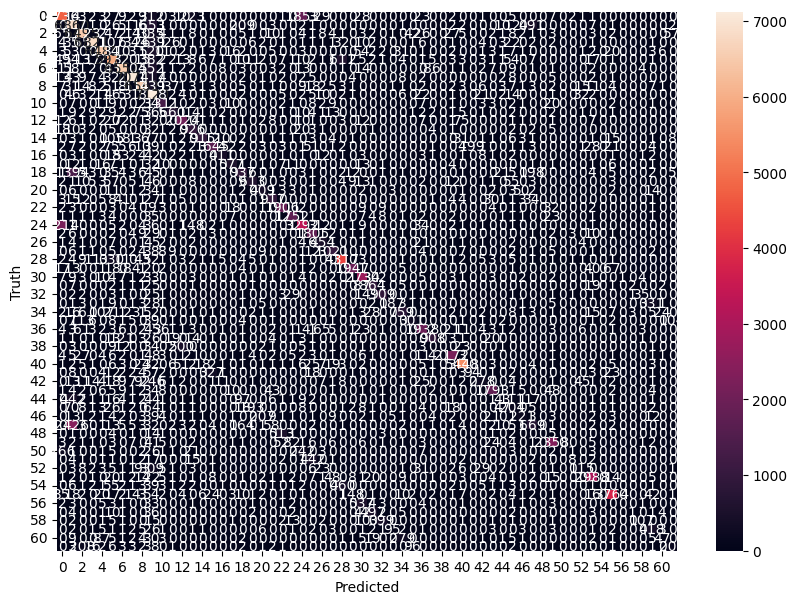

In [43]:
# Matrice de confusion
cm3 = tf.math.confusion_matrix(labels=y_test2, predictions=y_predicted_labels3)
plt.figure(figsize=(10, 7))
sns.heatmap(cm3, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')